# Visual exploration of a low-dimensional classification problem

Toolset:
- `matplotlib.subplots()` - a way to display multiple plots in a nice structure
- `pandas.DataFrame().groupby().plot(kind='awesomeness')` - yet another reason to love pandas
- putting a pandas plot into a matplotlib subplot
- `scipy.stats.kde.gaussian_kde()` - get a density function (PDF, KDE) in any number of dimensions
- `numpy.mgrid[]` - simple way to generate k:n vectors and fill them by applyig a pattern
- `numpy.ndarray.flatten()` - collapse an n dimensions vector into 1D
- `numpy.ndarray.reshape()` - pour it back into an n-dimension vector
- `numpy.vstack()` - a member of the \*stack function family that make it easy to split and merge vectors

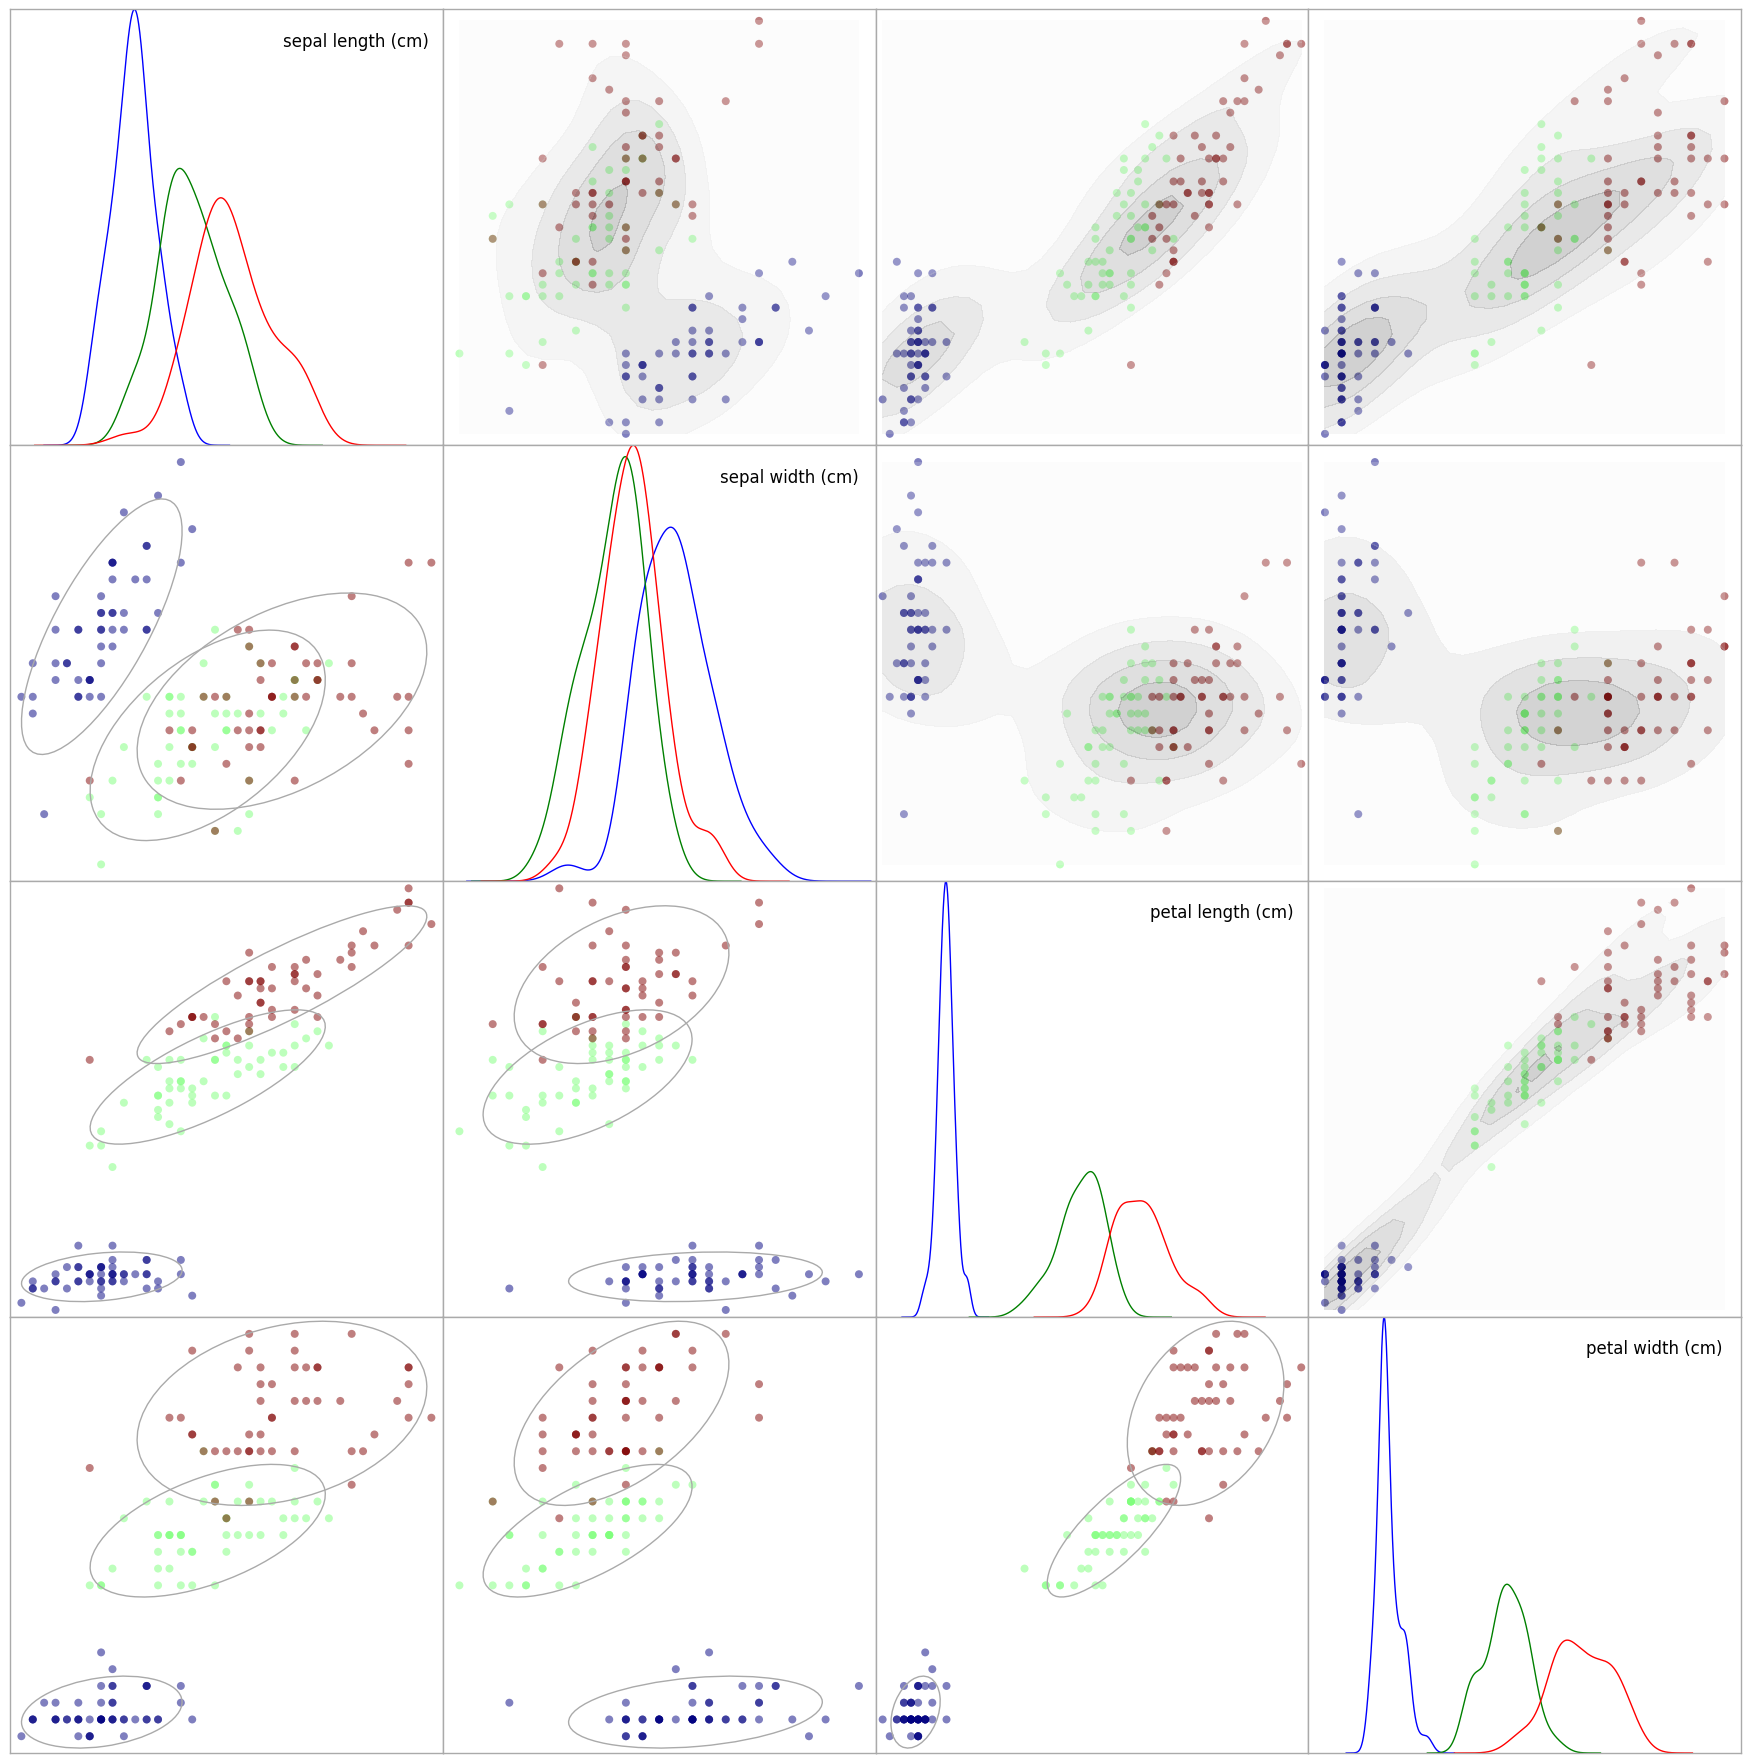

In [1]:
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
from sklearn import datasets
from scipy import stats
import pandas as pd


# settings
iris = datasets.load_iris()
data_len = len(iris.data)
vector_len = len(iris.feature_names)
data_t = iris.target
standard_deviations = 2
nbins = 30


# matplotlib init
%matplotlib inline
plt.rc('axes', edgecolor='#aaaaaa')
fig, plotmatrix = plt.subplots(nrows=vector_len, ncols=vector_len, figsize=(18,18), 
                               gridspec_kw={'hspace': 0, 'wspace': 0})

fig.tight_layout()


# iterating x and y axes of the scatterplot matrix
for axis_x in range(vector_len):
    
    data_x = iris.data.T[axis_x]
    axis_x_min = data_x.min()
    axis_x_max = data_x.max()
    
    for axis_y in range(vector_len):
    
        data_y = iris.data.T[axis_y]
        axis_y_min = data_y.min()
        axis_y_max = data_y.max()
        
        plot = plotmatrix[axis_y, axis_x]
        plot.get_xaxis().set_visible(False)
        plot.get_yaxis().set_visible(False)
        
        if axis_x == axis_y:
            
            pd.DataFrame(data_x).groupby(list(data_t)).plot(kind='kde', ax=plot, 
                                                            yticks=[], legend=False)
            plot.set_ylabel('')
            plot.set_title(iris.feature_names[axis_x], x=.8, y=.9)
            
        else:
            
            plot.scatter(data_x, data_y, c=data_t, s=33, lw=0, alpha=.5)
            
            plot.set_xlim(axis_x_min - .1, axis_x_max + .1)  # zooming in
            plot.set_ylim(axis_y_min - .1, axis_y_max + .1)  # zooming in
            
            plot.tick_params(axis='both', which='both', bottom='off', top='off', 
                      labelbottom='off', right='off', left='off', labelleft='off')
            
            if axis_x > axis_y:
            
                # 2d kde for smooth contourplot
                density = stats.kde.gaussian_kde([data_x, data_y])  
                xi, yi = pd.np.mgrid[axis_x_min:axis_x_max:nbins*1j, 
                                     axis_y_min:axis_y_max:nbins*1j]
                zi = density(pd.np.vstack([xi.flatten(), yi.flatten()]))

                plot.contourf(xi, yi, zi.reshape(xi.shape), 4, 
                              alpha=.2, cmap='Greys')

            if axis_x < axis_y:
                
                groups = pd.DataFrame([data_x, data_y]).T.groupby(data_t)
                
                for group in groups:
                    frame = group[1]
                    
                    # determining eigenvectors and value
                    covariance_matrix = pd.np.cov(frame.T)
                    eigenvalues, eigenvectors = pd.np.linalg.eigh(covariance_matrix)
                    order = eigenvalues.argsort()[::-1]
                    eigenvalues = eigenvalues[order]
                    eigenvectors = eigenvectors[:,order]
                    theta = pd.np.rad2deg(- pd.np.arctan2(*eigenvectors[0][::-1]) \
                                          % (2 * pd.np.pi))
                    width, height = 2 * standard_deviations * pd.np.sqrt(eigenvalues)
                    
                    # drawing 2sigma error ellipse around each groups
                    plot.add_artist(Ellipse(xy=[frame[0].mean(), frame[1].mean()],
                                            width=width, height=height, angle=theta, 
                                            fc='none', color='#aaaaaa'))